In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
data = pd.read_csv("raw_ppg.csv", index_col=['timer'], parse_dates=['timer'])
data.head(10)

,ppg
timer,
2022-10-28 10:48:00.003,2653440
2022-10-28 10:48:00.103,2650560
2022-10-28 10:48:00.205,2650767
2022-10-28 10:48:00.316,2653281
2022-10-28 10:48:00.403,2655284
2022-10-28 10:48:00.504,2657600
2022-10-28 10:48:00.604,2661857
2022-10-28 10:48:00.703,2658077
2022-10-28 10:48:00.810,2655382


In [ ]:
data.shape

(599, 1)

In [ ]:
data.dtypes

ppg    int64
dtype: object

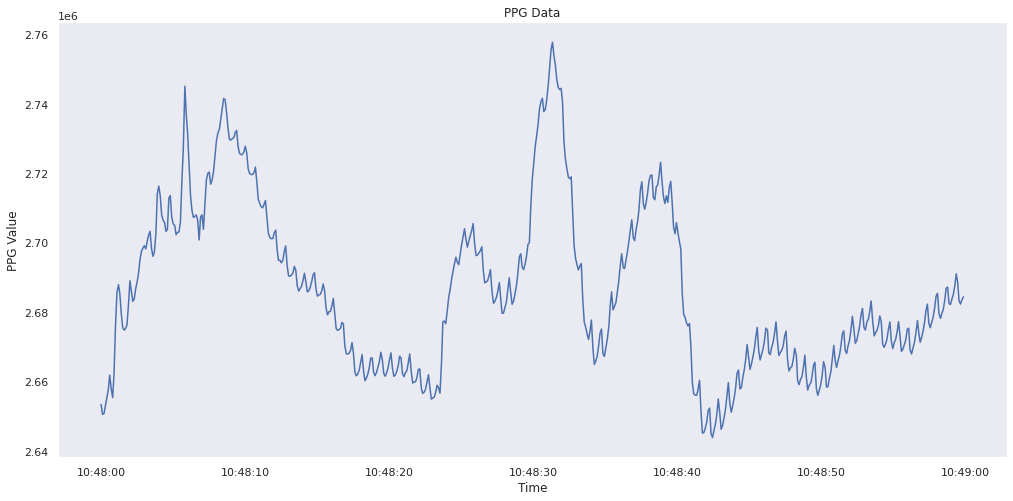

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(data.ppg)
plt.title('PPG Data')
plt.ylabel('PPG Value')
plt.xlabel('Time')
plt.grid(False)
plt.show()

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

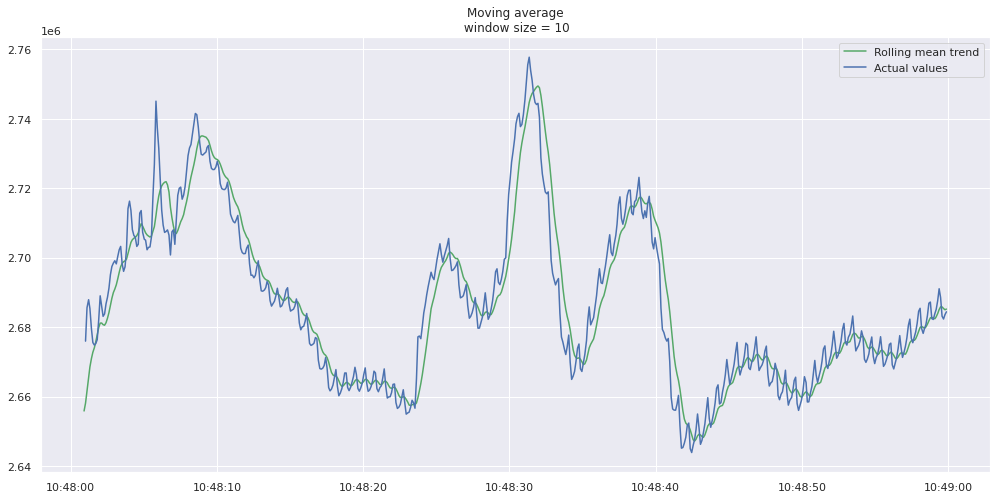

In [ ]:
plot_moving_average(data.ppg, 10)

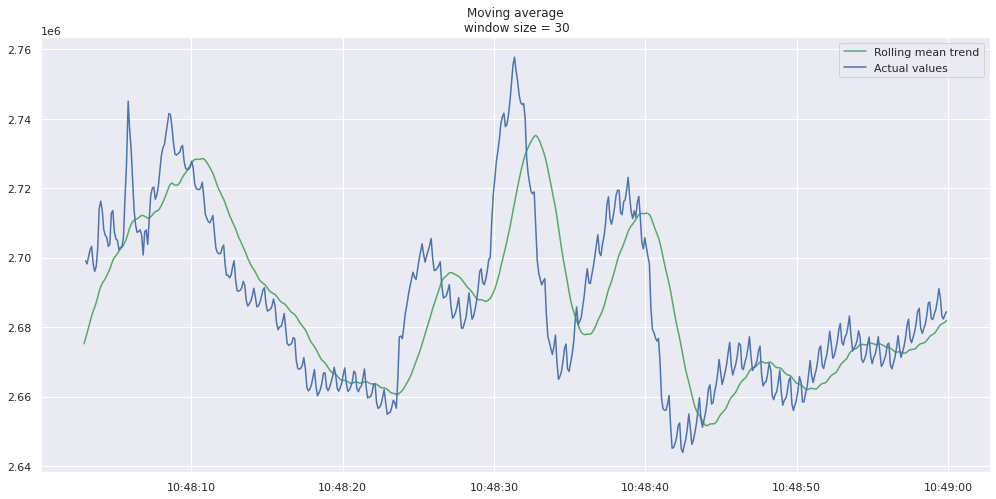

In [ ]:
plot_moving_average(data.ppg, 30)

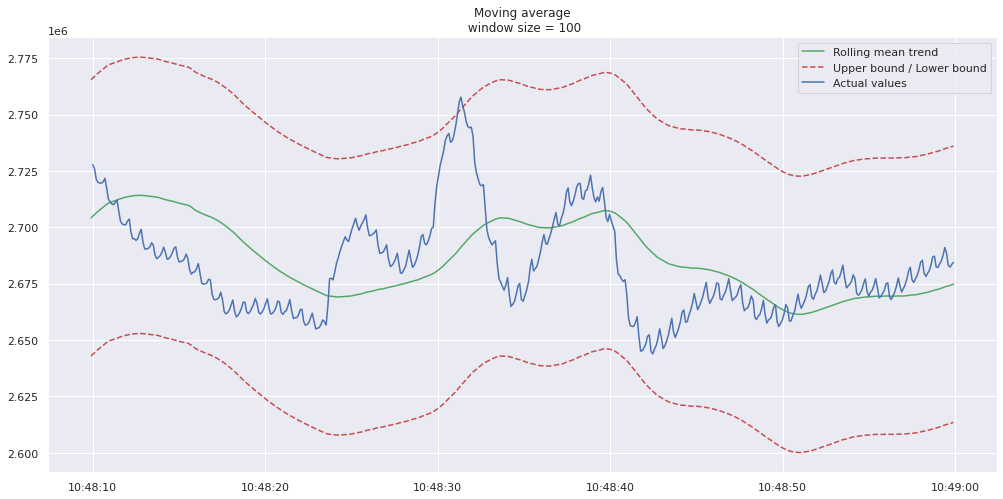

In [ ]:
plot_moving_average(data.ppg, 100, plot_intervals=True)

In [ ]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

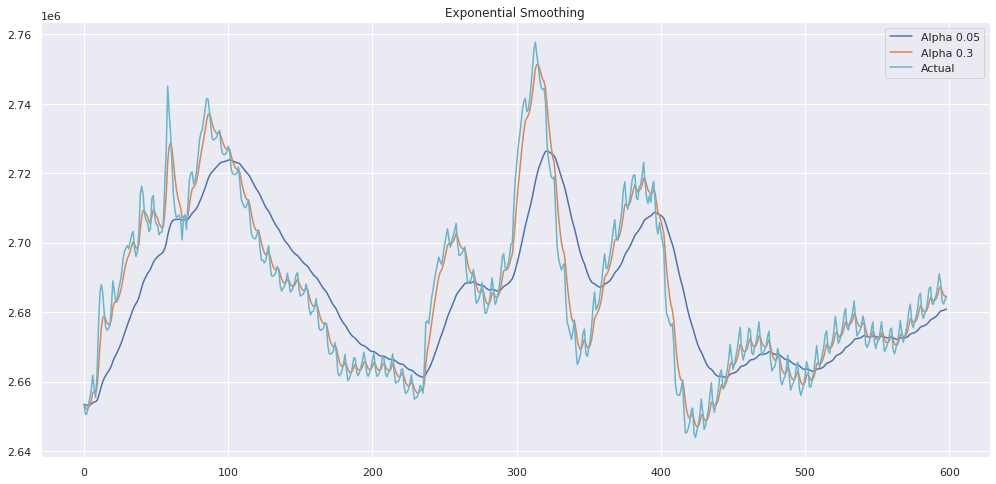

In [ ]:
plot_exponential_smoothing(data.ppg, [0.05, 0.3])

In [ ]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [ ]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

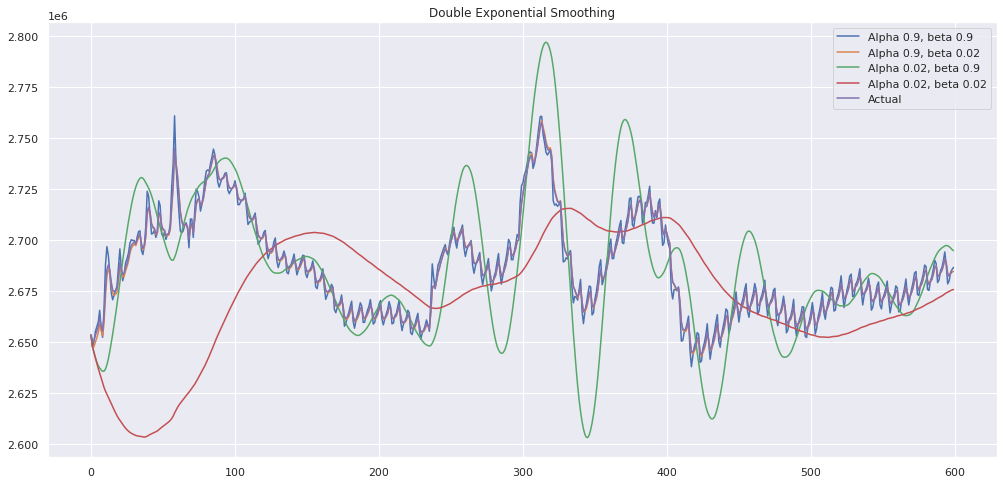

In [ ]:
plot_double_exponential_smoothing(data.ppg, alphas=[0.9, 0.02], betas=[0.9, 0.02])

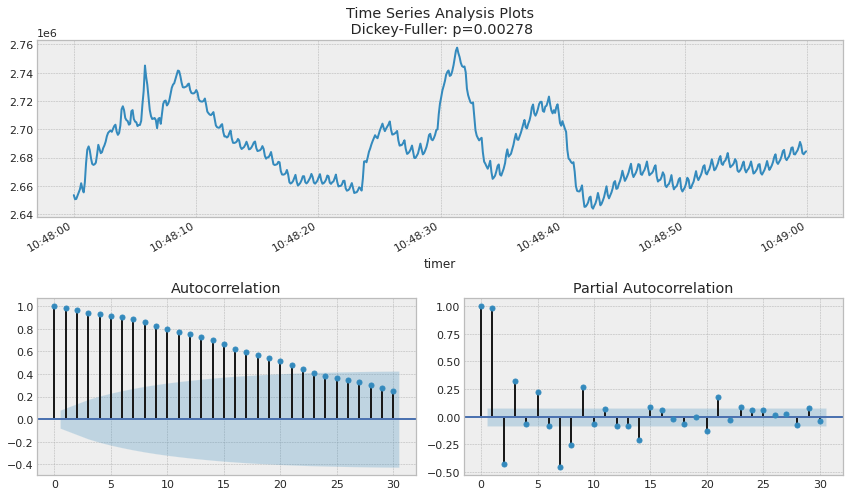

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.ppg, lags=30)

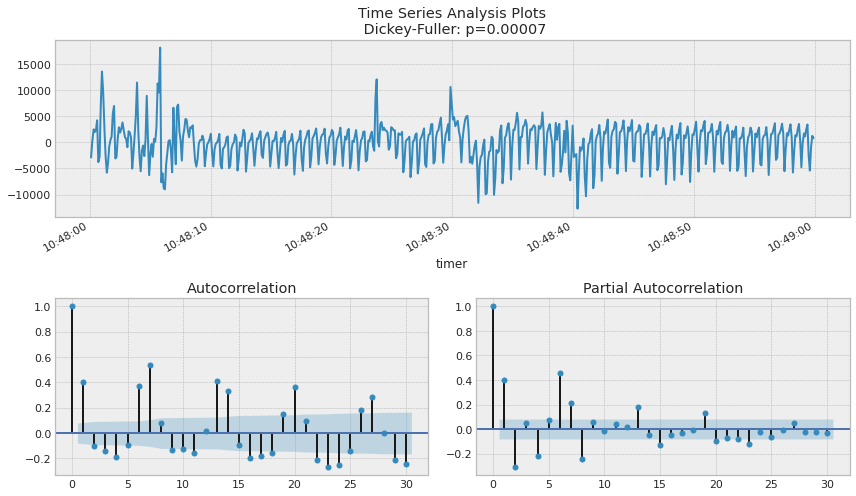

In [ ]:
data_diff = data.ppg - data.ppg.shift(1)
tsplot(data_diff[1:], lags=30)

In [ ]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.ppg, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

  0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.ppg, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                 ppg   No. Observations:                  599
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 5)   Log Likelihood               -5917.650
Date:                             Sat, 29 Oct 2022   AIC                          11843.300
Time:                                     00:26:03   BIC                          11860.840
Sample:                                          0   HQIC                         11850.131
                                             - 599                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0022      0.006     -0.375      0.708      -0.014       0.009
ar.S.L5       -0.6962      

In [ ]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'ppg': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 10)
print(best_model.predict(start=data.ppg.shape[0], end=data.ppg.shape[0] + 10))
print(mean_absolute_percentage_error(data.ppg[s+d:], best_model.fittedvalues[s+d:]))

599    2.681948e+06
600    2.676587e+06
601    2.675738e+06
602    2.677018e+06
603    2.677877e+06
604    2.675384e+06
605    2.670000e+06
606    2.669176e+06
607    2.670450e+06
608    2.671272e+06
609    2.668794e+06
Name: predicted_mean, dtype: float64
0.14647584996667862


In [ ]:
data_2 = pd.read_csv("ppg_test.csv", index_col=['timer'], parse_dates=['timer'])
data.head(10)

,ppg
timer,
2022-10-28 10:48:00.003,2653440
2022-10-28 10:48:00.103,2650560
2022-10-28 10:48:00.205,2650767
2022-10-28 10:48:00.316,2653281
2022-10-28 10:48:00.403,2655284
2022-10-28 10:48:00.504,2657600
2022-10-28 10:48:00.604,2661857
2022-10-28 10:48:00.703,2658077
2022-10-28 10:48:00.810,2655382


In [ ]:
comparison = pd.DataFrame({'actual': [2653440, 2653440, 2650767, 2653281, 2655284, 2657600, 2661857,2658077,2655382, 2662347],
                          'predicted': [2676587,2675738,2677018,2677877,2675384,2670000,2669176,2670450,2671272,2668794]}, 
                          index = pd.date_range(start='10:48:01.004', periods=10,))

In [ ]:
comparison.head()

,actual,predicted
2022-10-29 10:48:01.004,2653440,2676587
2022-10-30 10:48:01.004,2653440,2675738
2022-10-31 10:48:01.004,2650767,2677018
2022-11-01 10:48:01.004,2653281,2677877
2022-11-02 10:48:01.004,2655284,2675384


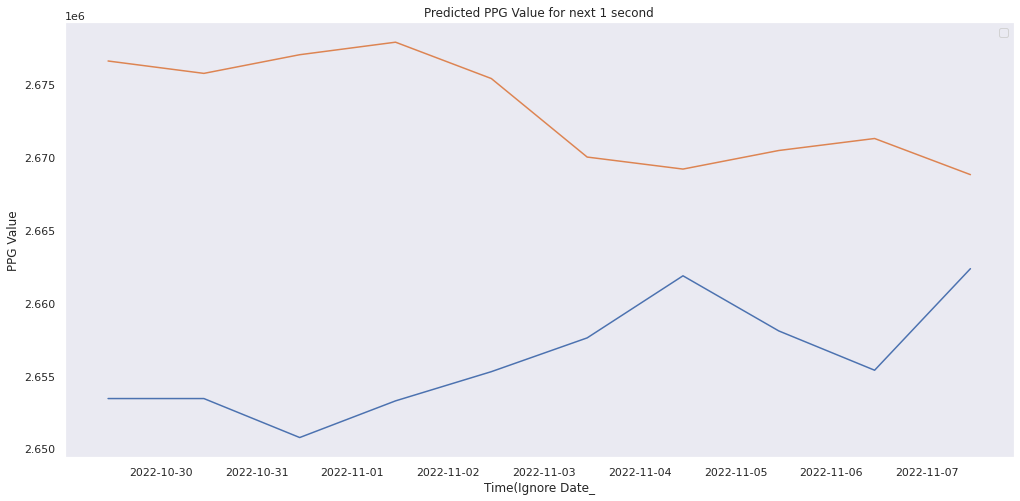

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicted PPG Value for next 1 second')
plt.ylabel('PPG Value')
plt.xlabel('Time(Ignore Date_')
plt.legend(loc='best')
plt.grid(False)
plt.show()